In [1]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.time import BaseScheduler
from mesa.batchrunner import BatchRunner
from mesa.datacollection import DataCollector
from mesa.visualization.modules import ChartModule
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


C:\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# De car agent class
In deze class wordt een auto-agent gemaakt, die twee waardes heeft: de snelheid en de positie op de weg. De functie 'accelerate' zorgt ervoor dat de auto versnelt als deze nog niet de maximale snelheid bereikt heeft (maximaal 5 in dit geval). Het massatraagvoertuig heeft een lager versnelling dus zal 1 speed minder snel optrekken dan een reguliere auto. De functie 'brake' zorgt ervoor dat de auto vertraagt als de volgende cel al bezet is door een andere auto. In dat geval wordt de snelheid met één verminderd en wordt de functie opnieuw aangeroepen om te kijken of de auto dan wel past. Voor het massatraag voertuig betekend dat de remweg groter is dan die van normale auto's. Als dat niet het geval is, wordt de snelheid verder verminderd totdat de auto past. In de functie 'move' verplaatst de auto zich naar de volgende cel, waarbij de afstand die de auto aflegt gelijk is aan zijn snelheid. Als de volgende cel bezet is, wordt de functie 'brake' opnieuw aangeroepen. In de functie 'randomazition_role' heeft de auto een 50% kans om zijn snelheid met één te verminderen.

In [2]:
class car_agent(Agent):
    max_speed = 5

    def __init__(self, pos, model, startup_time, braking_distance, massatraag=False):
        """Initialiseer de auto-agent met de opgegeven startpositie, het model, de opstarttijd, de remafstand en of het voertuig massatraag is."""
        super().__init__(pos, model)
        self.speed = random.randint(3, 5)
        self.pos = pos
        self.startup_time = startup_time
        self.braking_distance = braking_distance
        self.massatraag = massatraag  

    def accelerate(self):
        """Verhoog de snelheid van het voertuig als de opstarttijd voorbij is en de maximale snelheid niet is bereikt."""
        if self.startup_time > 0 and not self.massatraag:
            self.startup_time -= 3
        elif self.speed < self.max_speed:
            self.speed += 1

    def brake(self):
        """Verlaag de snelheid van het voertuig als er voor het voertuig geen lege cel meer is en de remafstand kleiner of gelijk is aan de huidige snelheid."""
        if not self.massatraag:
            braking_distance = self.speed * self.braking_distance / 100
            next_cell = self.model.grid.torus_adj((self.pos[0] + self.speed, self.pos[1]))
            while not self.model.grid.is_cell_empty(next_cell):
                if braking_distance > self.speed:
                    self.speed = 0
                    break
                elif self.speed > 0:
                    self.speed -= 1
                    braking_distance = self.speed * self.braking_distance / 100
                    next_cell = self.model.grid.torus_adj((self.pos[0] + self.speed, self.pos[1]))
                else:
                    break

    def move(self):
        """Verplaats het voertuig naar de volgende cel als deze leeg is."""
        next_cell = self.model.grid.torus_adj((self.pos[0] + self.speed, self.pos[1]))
        if self.model.grid.is_cell_empty(next_cell):
            self.model.grid.move_agent(self, next_cell)

    def randomization_role(self):
        """Verander de snelheid van het voertuig met een kans van 50% met 1 naar beneden."""
        if self.speed > 1:
            if random.choice([True, False]) == True:
                self.speed -= 1
            else:
                self.speed = self.speed

    def step(self):
        """Voer de stappen voor een tijdstap uit: remmen, versnellen, bewegen en de rol van randomisatie vervullen."""
        self.brake()
        self.accelerate()
        self.move()
        self.randomization_role()

# De CarModel class
De CarModel-klasse is verantwoordelijk voor het maken van auto's en het toewijzen van willekeurige posities op de weg, evenals het verzamelen van gegevens. In deze class wordt er als het nog niet gedaan is een massatraagvoertuig toegewezen aan de simulatie. Zo komt er per simulatie 1 massatraagvoertuig voor. Het verzamelen van gegevens is van groot belang voor dit onderzoek dit wordt gedaan met de datacollector van mesa. 

In [3]:
class car_model_base(Model):
    """ Een model zonder massatraag voertuig. 
    Maakt gebruik van een grid en bevat een DataCollector om data van de agents te verzamelen.
    """
    
    def __init__(self, height, width, car_amount):
        """
        Initialiseert het model met hoogte, breedte en aantal auto's. Maakt een BaseScheduler en DataCollector aan. Initialiseert
        het grid met de hoogte en breedte. Vervolgens worden de agents aangemaakt en toegevoegd aan het grid en de scheduler.
        
        Parameters:
        - height : aantal herhalingen van de simulatie
        - width : aantal herhalingen van de configuratie van de simulatie 
        - car_amount : aantal auto's dat aangemaakt moet worden
        """
        self.height = height
        self.width = width
        self.car_amount = car_amount

        self.schedule = BaseScheduler(self)
        self.data = DataCollector(agent_reporters={"Speed": "speed", "Position": "pos",
                                                    "Startup Time": "startup_time",
                                                    "Braking Distance": "braking_distance"})
        self.grid = SingleGrid(height, width, torus=True)

        self.create_agents()

        self.running = True

    def create_agents(self):
        """
        Maakt de agents aan en voegt ze toe aan het grid en de scheduler. Bij een Exception wordt opnieuw geprobeerd een agent
        aan te maken totdat het lukt.
        """
        for i in range(self.car_amount):
            while True:
                try:
                    r = random.random()
                    startup_time = random.randint(1, 3)
                    braking_distance = random.randint(10, 20)
                    # Alle voertuigen worden aangemaakt zonder massatraag attribuut (massatraag=False)
                    agent = car_agent((int(r * 100), 5), self, startup_time, braking_distance, massatraag=False)
                    self.grid.position_agent(agent, int(r * 100))
                    self.schedule.add(agent)
                    break
                except Exception as e:
                    continue
                    
        self.running = True            
        self.data.collect(self)
        
    def step(self):
        self.schedule.step()
        self.data.collect(self)
        
    def run_model(self, steps):
        for i in range(steps):
            self.step()
            
    def get_agent_speed(self, agent):
        return agent.speed
    
    def get_agent_position(self, agent):
        return agent.pos
    
    def get_agent_startup_time(self, agent):
        return agent.startup_time
    
    def get_agent_braking_distance(self, agent):
        return agent.braking_distance
    
    def get_agent_data(self, agent):
        return {"Speed": agent.speed, "Position": agent.pos, "Startup Time": agent.startup_time, 
                "Braking Distance": agent.braking_distance}
    
    def get_model_data(self):
        # Gebruik de collect() methode om de gegevens van alle agents op te halen
        speed_data = self.data.get_agent_vars_dataframe()
        position_data = self.data.get_agent_vars_dataframe()
        startup_time_data = self.data.get_agent_vars_dataframe()
        braking_distance_data = self.data.get_agent_vars_dataframe()
        
        # Geef de verzamelde gegevens terug als een dictionary
        return {"Speed": speed_data, "Position": position_data, "Startup Time": startup_time_data, "Breaking Distance": braking_distance_data}

In [4]:
class car_model(Model):
    
    def __init__(self, height, width, car_amount):
        self.height = height
        self.width = width
        self.car_amount = car_amount

        self.schedule = BaseScheduler(self)
        self.data = DataCollector(agent_reporters={"Speed": "speed", "Position": "pos",
                                                    "Startup Time": "startup_time",
                                                    "Braking Distance": "braking_distance"})
        self.grid = SingleGrid(height, width, torus=True)

        self.create_agents()

        self.running = True

    def create_agents(self):
         # Bij het aanmaken van de auto's wordt er rekening gehouden met het massatraagvoertuig, als deze nog niet is aangemaakt wordt er een masssatraagvoertuig aangemaakt.
        massatraag_created = False  # Bij te houden of 1 van de voertuigen al massatraag is
        for i in range(self.car_amount):
            while True:
                try:
                    r = random.random()
                    startup_time = random.randint(1, 3)
                    braking_distance = random.randint(5, 15)
                    # Als het massatraag voertuig nog niet is aangemaakt, stel de massatraag parameter in op True
                    if not massatraag_created:
                        agent = car_agent((int(r * 100), 5), self, startup_time, braking_distance, massatraag=True)
                        massatraag_created = True
                    else:
                        agent = car_agent((int(r * 100), 5), self, startup_time, braking_distance, massatraag=False)
                    self.grid.position_agent(agent, int(r * 100))
                    self.schedule.add(agent)
                    break
                except Exception as e:
                    continue

        self.running = True            
        self.data.collect(self)
        
    def step(self):
        self.schedule.step()
        self.data.collect(self)
        
    def run_model(self, steps):
        for i in range(steps):
            self.step()
            
    def get_agent_speed(self, agent):
        return agent.speed
    
    def get_agent_position(self, agent):
        return agent.pos
    
    def get_agent_startup_time(self, agent):
        return agent.startup_time
    
    def get_agent_braking_distance(self, agent):
        return agent.braking_distance
    
    def get_agent_data(self, agent):
        return {"Speed": agent.speed, "Position": agent.pos, "Startup Time": agent.startup_time, 
                "Braking Distance": agent.braking_distance}
    
    def get_model_data(self):
        # Gebruik de collect() methode om de gegevens van alle agents op te halen
        speed_data = self.data.get_agent_vars_dataframe()
        position_data = self.data.get_agent_vars_dataframe()
        startup_time_data = self.data.get_agent_vars_dataframe()
        braking_distance_data = self.data.get_agent_vars_dataframe()
        
        # Geef de verzamelde gegevens terug als een dictionary
        return {"Speed": speed_data, "Position": position_data, "Startup Time": startup_time_data, "Breaking Distance": breaking_distance_data}

### Data Collection
Met de ingebouwde datacollecter van mesa wordt de data van de simulatie opgeslagen. De data kan dan geanalyseerd worden met behulp van grafieken en tabellen hieruit kunnen conclusie worden getrokken.

### De grafieken
In grafiek 1 en 2 (grafiek 1 is zonder massatraagvoertuig) ziet u hoevaak elke snelheid is voorgekomen in de simulatie, dit kan inzicht geven in de doorstroming van het verkeer, als er namelijk vaker lage snelheden voorkomen zal de doorstroming minder 'goed' zijn, in grafiek 1 en 2 in de Y-as het aantal auto's en de X-as is de snelheid.

### Batch run
runt het programma 500 keer per verschillende agents dus bij 10 voertuigen begint het en eindigt op 90 voertuigen. Dit wordt gedaan zodat er meer data is voor de resultaten om daar conclusie van te trekken.

In [5]:
fixed_params = {"height": 500,
               "width": 1} # 500 herhalingen per simulatie 
variable_params = {"car_amount": range(10, 100, 10)} # er komen steeds 10 voertuigen (agents) bij
# geen masssatraagvoertuig
batch_run_base = BatchRunner(car_model_base,
                        variable_params,
                        fixed_params,
                        iterations=10,
                        max_steps=100,
                        agent_reporters={"Speed": "speed"})
batch_run_base.run_all()

90it [00:02, 30.05it/s] 


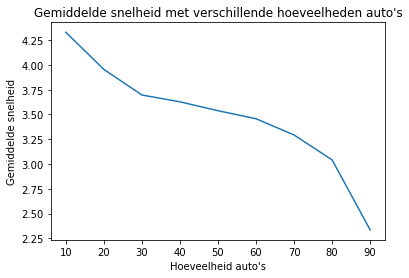

In [6]:
car_amounts = [10, 20, 30, 40, 50, 60, 70, 80, 90]
mean_speeds = []
#geen massatraagvoertuig
run_data_base = batch_run_base.get_agent_vars_dataframe()

for car_amount in car_amounts:
    specifieke_car_amount = run_data_base.loc[(run_data_base['car_amount'] == car_amount)]
    mean_speed = specifieke_car_amount['Speed'].mean()
    mean_speeds.append(mean_speed)

# Plot de gemiddelde snelheid voor elke hoeveelheid auto's
plt.plot(car_amounts, mean_speeds)
plt.xlabel("Hoeveelheid auto's")
plt.ylabel('Gemiddelde snelheid')
plt.title("Gemiddelde snelheid met verschillende hoeveelheden auto's")
plt.show()

In [7]:
fixed_params = {"height": 500,
               "width": 1} # 500 herhalingen per simulatie
variable_params = {"car_amount": range(10, 100, 10)} # er komen steeds 10 voertuigen (agents) bij

batch_run = BatchRunner(car_model,
                        variable_params,
                        fixed_params,
                        iterations=10,
                        max_steps=100,
                        agent_reporters={"Speed": "speed"})
batch_run.run_all()

90it [00:02, 30.19it/s] 


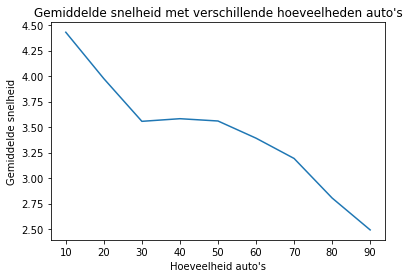

In [8]:
car_amounts = [10, 20, 30, 40, 50, 60, 70, 80, 90]
mean_speeds = []

run_data = batch_run.get_agent_vars_dataframe()

for car_amount in car_amounts:
    specifieke_car_amount = run_data.loc[(run_data['car_amount'] == car_amount)]
    mean_speed = specifieke_car_amount['Speed'].mean()
    mean_speeds.append(mean_speed)

# Plot de gemiddelde snelheid voor elke hoeveelheid auto's
plt.plot(car_amounts, mean_speeds)
plt.xlabel("Hoeveelheid auto's")
plt.ylabel('Gemiddelde snelheid')
plt.title("Gemiddelde snelheid met verschillende hoeveelheden auto's")
plt.show()

### tabellen en grafieken
In deze tabel is goed te zien wat de gemiddelde sneilheid is per simulatie.
In de grafieken worden de snelheden gegroepeerd per hoeveelheid auto's die gesimuleerd zijn. 

In [9]:
run_data.describe() # met massatraagvoertuig

,car_amount,Run,Speed,height,width
count,4500.000000,4500.000000,4500.000000,4500.0,4500.0
mean,63.333333,57.833333,3.172222,500.0,1.0
std,22.113289,22.299089,1.347701,0.0,0.0
min,10.000000,0.000000,1.000000,500.0,1.0
25%,50.000000,42.000000,2.000000,500.0,1.0
50%,70.000000,62.000000,3.000000,500.0,1.0
75%,80.000000,77.000000,4.000000,500.0,1.0
max,90.000000,89.000000,5.000000,500.0,1.0


In [10]:
run_data_base.describe() # zonder massatraagvoertuig

,car_amount,Run,Speed,height,width
count,4500.000000,4500.000000,4500.000000,4500.0,4500.0
mean,63.333333,57.833333,3.214667,500.0,1.0
std,22.113289,22.299089,1.336032,0.0,0.0
min,10.000000,0.000000,1.000000,500.0,1.0
25%,50.000000,42.000000,2.000000,500.0,1.0
50%,70.000000,62.000000,3.000000,500.0,1.0
75%,80.000000,77.000000,4.000000,500.0,1.0
max,90.000000,89.000000,5.000000,500.0,1.0


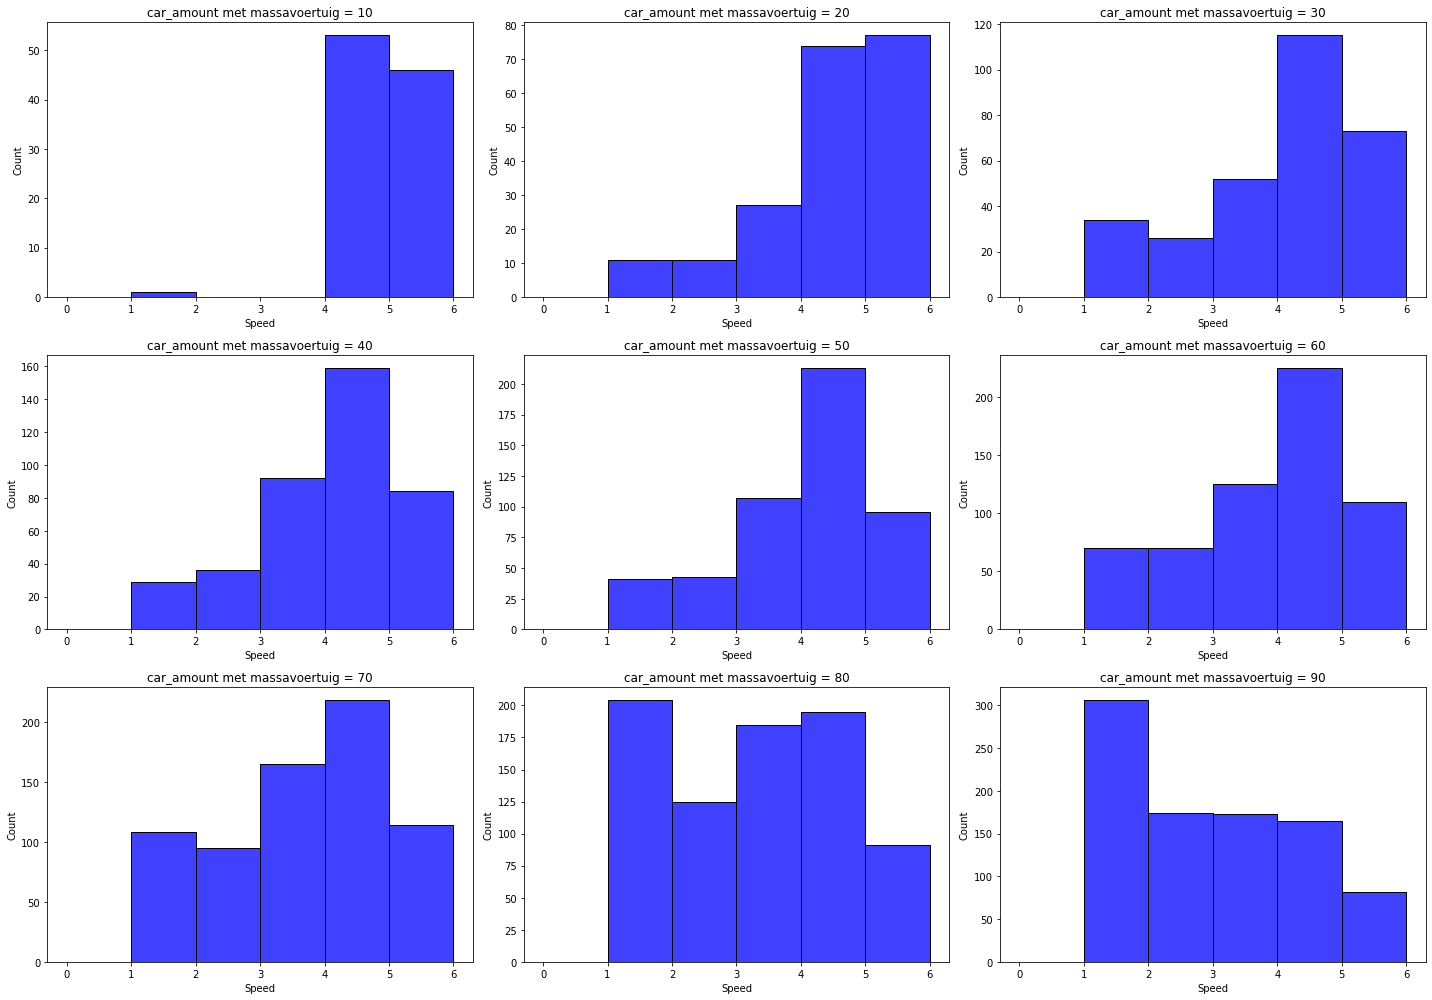

In [11]:
# Stel de figuur grootte in
plt.figure(figsize=(20, 14))

# Loop over elke car_amount groep en maak een histogram voor de snelheden
for car_amount in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    data = run_data[run_data['car_amount'] == car_amount]
    plt.subplot(3, 3, (car_amount // 10))
    sns.histplot(data=data, x='Speed', bins=range(7), color='blue')
    plt.title(f'car_amount met massavoertuig = {car_amount}')

# Zorg dat de plot er netjes uitziet
plt.tight_layout()
plt.show()


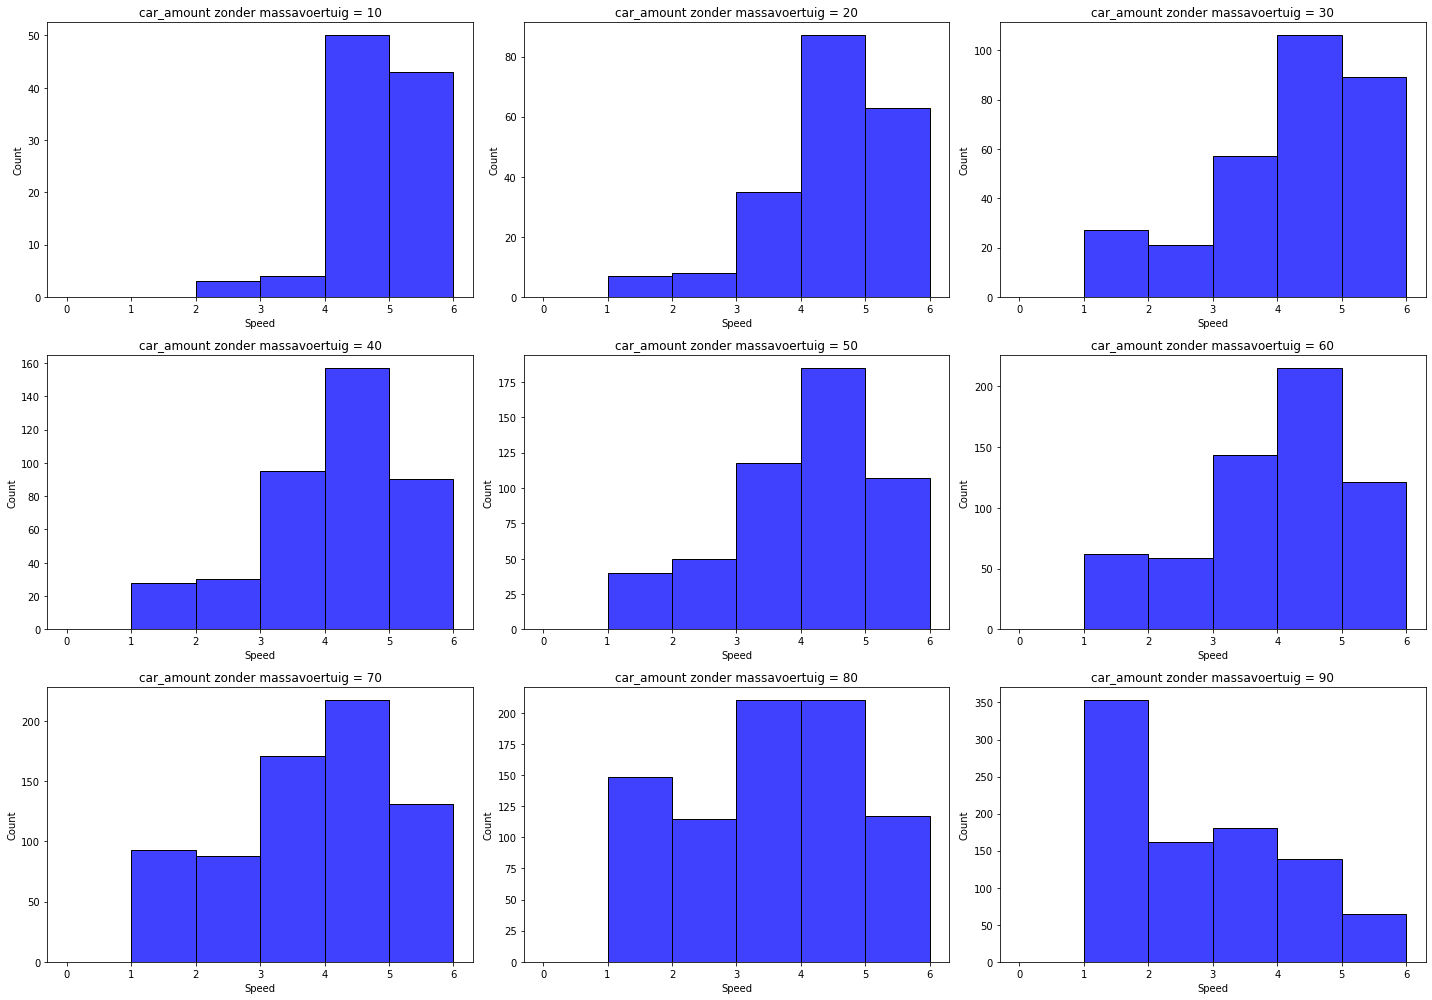

In [12]:
# Stel de figuur grootte in
plt.figure(figsize=(20, 14))

# Loop over elke car_amount groep en maak een histogram voor de snelheden
for car_amount in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    data = run_data_base[run_data_base['car_amount'] == car_amount]
    plt.subplot(3, 3, (car_amount // 10))
    sns.histplot(data=data, x='Speed', bins=range(7), color='blue')
    plt.title(f'car_amount zonder massavoertuig = {car_amount}')

# Zorg dat de plot er netjes uitziet
plt.tight_layout()
plt.show()

### conclusie

Het massatraagvoertuig heeft minimaal effect op de doorstroom van de weg. Zonder massatraagvoertuig is de doorstroom net zo goed als met massatraagvoertuig. Dit komt denk ik doordat het maar 1 massatraagvoertuig is. 

### visalisatie
eerst een keer reset drukken dan doet die het goed. 

In [13]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter

def car_draw(agent):

    if agent.speed > 3:
        color = 'green'
    elif 1 < agent.speed < 4:
        color = 'orange'  # Fixed typo in color name
    elif agent.speed < 2:
        color = 'red'
    return {"Shape": "rect", "w": 0.5, "h": 40, "Filled": "true", "Layer": 0, "Color": color, "stroke_color": "#00FF00"}

canvas_element = CanvasGrid(car_draw, 100, 1, 500, 500)

model_params = {
    "height": 1000,
    "width": 1,
    "car_amount": UserSettableParameter("slider", "Number of Cars", 10, 1, 100 , 1)}

server = ModularServer(car_model,
                       [canvas_element],
                       "Nagel-Schreckenberg", model_params)
server.port = 8541 
server.launch()

Interface starting at http://127.0.0.1:8541


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
